# Research Case 2: 
 ## Machine learning sentiment analysis

In this notebook, we go over machine learning approaches including Navie Bayes and Support Vector Machine (SVM) to classify the sentiment of tweets about airlines.

![Plane](https://freepngimg.com/thumb/airplane/26315-7-airplane-transparent.png)



### Import Required Libraries
We start by importing required packages. Also, we need import metrics of model measurements.


In [1]:
# import metrics to measure accuracy, recall, precision and F1
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, recall_score, precision_score, balanced_accuracy_score
from sklearn.metrics import classification_report, confusion_matrix, plot_confusion_matrix, classification_report

# Import libraries and packages
import pandas as pd
import numpy as np
import copy, re
import string
import nltk
from nltk import pos_tag
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.corpus import stopwords, wordnet
from sklearn.feature_extraction.text import TfidfVectorizer
import time
import emoji
import matplotlib.pyplot as plt

nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')



[nltk_data] Downloading package stopwords to /Users/luyu/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/luyu/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /Users/luyu/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


### Load Twitter Data
We load in tweets about airlines. Our dataset is composed of tweets about  airlines and sentiment labels. Sentiment labels of tweets were prelabeled in three categories: positive (1), neutural (0), and negative (-1).

In [2]:
df = pd.read_csv("../Airline-Sentiment.csv", encoding='utf8')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14640 entries, 0 to 14639
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   ID          14640 non-null  int64  
 1   sentiment   14640 non-null  int64  
 2   confidence  14640 non-null  float64
 3   text        14640 non-null  object 
dtypes: float64(1), int64(2), object(1)
memory usage: 457.6+ KB


In [4]:
df = df.fillna("")
df['confidence'] = pd.to_numeric(df['confidence'])
df['sentiment'] = pd.to_numeric(df['sentiment'])
df = df.loc[df['confidence'] >= 0.6]
df = df.reset_index()
df = df.drop(columns=['index'])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14402 entries, 0 to 14401
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   ID          14402 non-null  int64  
 1   sentiment   14402 non-null  int64  
 2   confidence  14402 non-null  float64
 3   text        14402 non-null  object 
dtypes: float64(1), int64(2), object(1)
memory usage: 450.2+ KB


### Data Preparation
#### 1. Assign parts of speech to each word
 Part of Speech Tagging (POS) is a process of tagging sentences with part of speech such as nouns, verbs, adjectives and adverbs, etc.

In [5]:
def get_wordnet_pos(pos_tag):
    if pos_tag.startswith('J'):
        return wordnet.ADJ
    elif pos_tag.startswith('V'):
        return wordnet.VERB
    elif pos_tag.startswith('N'):
        return wordnet.NOUN
    elif pos_tag.startswith('R'):
        return wordnet.ADV
    else:
        return None

#### 2. Data cleaning
 We need to clean the tweets before we start analyzing it. We perform the following actions. We remove unnecessary line breaks that mess up data structure (# remove extra line breaks).


In [6]:
def clean_text(text):
    # lower the text
    text = text.lower()
    
    # remove mentions @
    text = re.sub(r'(@|#)[^ ]*([ ]|$)', '', text)
    
    # remove extra line breaks
    text = re.sub(r'(\r\n)+', '\r\n', text)
    text = re.sub(r'(\r)+', '\r', text)
    text = re.sub('(\n)+', '\n', text)
    text = re.sub(r'[^a-zA-Z ]', '', text)
    text = re.sub(r'[ ]+', ' ', text)
    text = text.replace('\r\n', '')\
        .replace('\r', '')\
        .replace('\n', '')
    text = text.strip()
    
    # remove hyperlink
    text = re.sub(r'http.?://[^\s]+[\s]?', '', text)
    
    # converting emoji
    text = emoji.demojize(text)
    text = re.sub(r':[a-z_&]+:', '', text)

    # replace all types of negations: no, n't, never
    text = text.replace("he's", "he is").replace("I'm", "I am").replace("'re", " are").replace("ain't", "are not")\
    .replace("'ve", " have").replace("'ll", " will").replace("won't", "will not").replace("can't", "can not")\
    .replace("n't", " not").replace("'d", " would")
    
    # remove all symbols
    text = re.sub(r'\[.*?\]', '', text)
    text = re.sub(r'[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub(r'\w*\d\w*', '', text)

    # tokenize the text with removal of non-words,  punctuation, short (< 3 symbols) and long (> 25 symbols) tokens
    text = [word.strip() for word in text.split() if len(word.strip()) >= 3 and len(word.strip()) <= 25]

    # filtering English stopwords, and remove digits
    stop = stopwords.words('english')
    text = [word for word in text if not any(c.isdigit() for c in word)]
    text = [word for word in text if word not in stop]

    # Part-Of-Speech (POS) tagging based on WordNet lexical database (retaining nouns and adjectives)
    pos_tags = pos_tag(text)
    pos_tags = list(filter(lambda x: get_wordnet_pos(x[1]) is not None, pos_tags))
    text = [w for w, t in pos_tags if get_wordnet_pos(t) == wordnet.NOUN or get_wordnet_pos(t) == wordnet.ADJ]

    # stemming (reducing inflected words to their word stems using Porter stemmer)
    stemmer = PorterStemmer()
    text = [stemmer.stem(word) for word in text]

    # lemmatize the text: transform every word into their root form (e.g. flights -> flight, went -> go)
    text = [WordNetLemmatizer().lemmatize(w, get_wordnet_pos(t)) for w, t in pos_tags]
 
    # join the token
    text = ' '.join(text)
    return(text)

### Data Processing
 We creat a new variable 'tweet_clean' for cleaned tweets. Also, we transfrom sentiment label '-1, 0, 1' to negative, neutral, and positive and count sentiments of tweets.

In [7]:
df["tweet_clean"] = df["text"].apply(lambda x: clean_text(x))

In [8]:
# total tweets in dataset
labels = []
tweets = []

num_of_total = 0
num_of_neutral = 0
num_of_pos = 0
num_of_neg = 0
for index in range(0, df.shape[0]):
    if df['sentiment'][index] == 0:
        num_of_neutral += 1
    elif df['sentiment'][index] == 1:
        num_of_pos += 1
    elif df['sentiment'][index] == -1:
        num_of_neg += 1
        # continue
    labels.append(df['sentiment'][index])
    tweets.append(df['tweet_clean'][index])
    num_of_total += 1
    
print("[%s] neutral tweets." % str(num_of_neutral))
print("[%s] postive tweets." % str(num_of_pos))
print("[%s] negtive tweets." % str(num_of_neg))
print("[%s] train and validation rows." % str(num_of_total))

tweets_tokens = [r for r in tweets]

[2997] neutral tweets.
[2292] postive tweets.
[9113] negtive tweets.
[14402] total rows.


### Training and Testing sets
 We split tweets into training and testing data set (test_size = 0.1).

In [9]:
# split data into training set and test set
x_train, x_test, y_train, y_test = train_test_split(tweets_tokens, labels, test_size=0.1, random_state=1)

In [10]:
# number of tweets in testing set
x_test.__len__()

1441

In [11]:
# number of tweets in training set
x_train.__len__()

12961

### Identify Number of Features


In [12]:
# find max features
_tf = TfidfVectorizer()
_xt = _tf.fit_transform(x_train)
_xtest = _tf.fit_transform(x_test)
_tf.vocabulary_.__len__()

2575

### Initialize Machine Learning Models
We set up machine learning models based on differnt algorithms including SVM classifier with the LinearSVC; Bernoulli and Multinomial Bayes classifiers. We could set parameters of features to modify the diagrams.

In [13]:
# encoding label using LabelEncoder()
from sklearn.preprocessing import LabelEncoder

MIN_FEATURE = 50 # inclusive
SELECTED_FEATURE = 300
MAX_FEATURE = 2050 # exclusive
FEATURE_INTERVAL = 50
SELECTED_CLASS_POSITION = 0

training_methods = []

# metrics 
metrics = {"performance": [], "accuracy": [], "balanced_accuracy": [], "precision": [], "recall": [], "f1": []}

# create our SVM classifier with the LinearSVC
from sklearn.svm import LinearSVC
training_methods.append((LinearSVC(), "linear svc", copy.deepcopy(metrics)))

# create our Bayes classifier with the BernoulliNB
from sklearn.naive_bayes import BernoulliNB
training_methods.append((BernoulliNB(binarize=None), "bayes with bernoulliNB", copy.deepcopy(metrics)))

# create our Bayes classifier with the MultinomialNB
from sklearn.naive_bayes import MultinomialNB
training_methods.append((MultinomialNB(), "bayes with multinomialNB", copy.deepcopy(metrics)))



### Feature Extraction and Confusion Metrics
We extract feature by TFIDF vectorizer.TFIDF helps us convert textual tweets to numeric form. The vector value it yields is the product of Term Frequency (TF) and Inverse Document Frequency (IDF). We also compute the confusion metrics based on 'true positve,' 'false positive,' 'false negative,' and' true negative.'

Model [linear svc] at [300] features ->



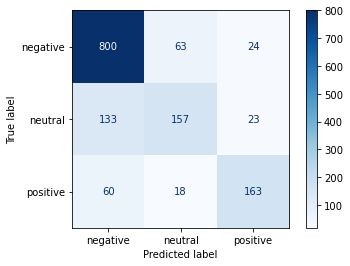

0.7690068772980091
0.7772380291464261
TruePositive: 163
FalsePositive: 47
FalseNegative: 78
TrueNegative: 1153


              precision    recall  f1-score   support

          -1      0.806     0.902     0.851       887
           0      0.660     0.502     0.570       313
           1      0.776     0.676     0.723       241

    accuracy                          0.777      1441
   macro avg      0.747     0.693     0.715      1441
weighted avg      0.769     0.777     0.769      1441

Model [bayes with bernoulliNB] at [300] features ->



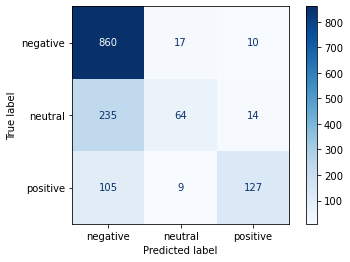

0.7362640356346438
0.7293546148507981
TruePositive: 127
FalsePositive: 24
FalseNegative: 114
TrueNegative: 1176


              precision    recall  f1-score   support

          -1      0.717     0.970     0.824       887
           0      0.711     0.204     0.318       313
           1      0.841     0.527     0.648       241

    accuracy                          0.729      1441
   macro avg      0.756     0.567     0.597      1441
weighted avg      0.736     0.729     0.685      1441

Model [bayes with multinomialNB] at [300] features ->



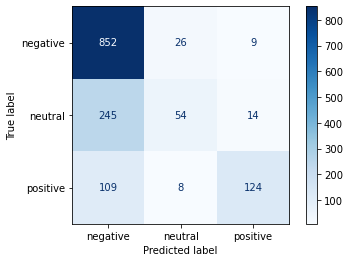

0.7092279769225417
0.7147814018043026
TruePositive: 124
FalsePositive: 23
FalseNegative: 117
TrueNegative: 1177


              precision    recall  f1-score   support

          -1      0.706     0.961     0.814       887
           0      0.614     0.173     0.269       313
           1      0.844     0.515     0.639       241

    accuracy                          0.715      1441
   macro avg      0.721     0.549     0.574      1441
weighted avg      0.709     0.715     0.667      1441



In [14]:
# Vectorize all tweets
for n_features in range(MIN_FEATURE, MAX_FEATURE, FEATURE_INTERVAL):
    tfidf_vect = TfidfVectorizer(max_features=n_features)

    _x_train = tfidf_vect.fit_transform(x_train)
    _x_test = tfidf_vect.transform(x_test)

    for tm, name, metrics in training_methods:
        tm.fit(_x_train, y_train)
        
        prediction = tm.predict(_x_test)
        
        #print(confusion_matrix(y_test, prediction).ravel())
        
        tnpn, tnpne, tnpp, tnepn, tnepne, tnepp, tppn, tppne, tppp = [int(x) for x in confusion_matrix(y_test, prediction, labels=[-1,0,1]).ravel()]
        tp = tppp
        fp = tnpp + tnepp
        fn = tppne + tppn
        tn = tnepne + tnpn + tnepn + tnpne
        
        _accuracy_score = accuracy_score(y_test, prediction)
        _balanced_accuracy_score = balanced_accuracy_score(y_test, prediction)
        _precision_score = precision_score(y_test, prediction, average='weighted') 
        _recall_score = recall_score(y_test, prediction, average='weighted')
        _f1_score = f1_score(y_test, prediction, average='weighted')
        
        
        #The 3-class classification Confusion Matrix using three models.
        if n_features == SELECTED_FEATURE:
            print("Model [%s] at [%d] features ->\n" % (name, n_features))
            plot_confusion_matrix(tm, _x_test, y_test, display_labels=['negative', 'neutral', 'positive'], cmap=plt.cm.Blues)  
            plt.show()
            print(_precision_score)
            print(_recall_score)
            print("TruePositive: %d" % tp)
            print("FalsePositive: %d" % fp)
            print("FalseNegative: %d" % fn)
            print("TrueNegative: %d\n\n" % tn)
            print(classification_report(y_test, prediction, digits=3))
        
        metrics["performance"].append((n_features, _performance_score))
        metrics["accuracy"].append((n_features, _accuracy_score))
        metrics["balanced_accuracy"].append((n_features, _balanced_accuracy_score))
        metrics["precision"].append((n_features, _precision_score))
        metrics["recall"].append((n_features, _recall_score))
        metrics["f1"].append((n_features, _f1_score))

### Diagrams of Different Models
We draw diagrams to see models' performance based on accuracy, precision, recall, and F1 scores along with the number of features. We also include balanced accuracy scores due to the uneven data distribution.

In [15]:
# draw the diagram
nfeatures_performance = []
nfeatures_accuracy = []
nfeatures_balanced_accuracy = []
nfeatures_precision = []
nfeatures_recall = []
nfeatures_f1 = []
for tm, name, metrics in training_methods:
    nfeatures_performance.append((name, pd.DataFrame(metrics['performance'], columns=['n_features', 'performance_score'])))
    nfeatures_accuracy.append((name, pd.DataFrame(metrics['accuracy'], columns=['n_features', 'accuracy_score'])))
    nfeatures_balanced_accuracy.append((name, pd.DataFrame(metrics['balanced_accuracy'], columns=['n_features', 'balanced_accuracy_score'])))
    nfeatures_precision.append((name, pd.DataFrame(metrics['precision'], columns=['n_features', 'precision_score'])))
    nfeatures_recall.append((name, pd.DataFrame(metrics['recall'], columns=['n_features', 'recall_score'])))
    nfeatures_f1.append((name, pd.DataFrame(metrics['f1'], columns=['n_features', 'f1_score'])))

=== Accuracy Score ===

Model Name [linear svc] has max accuracy score [0.798057] at [700] # of features
Model Name [bayes with bernoulliNB] has max accuracy score [0.743234] at [550] # of features
Model Name [bayes with multinomialNB] has max accuracy score [0.745316] at [1800] # of features


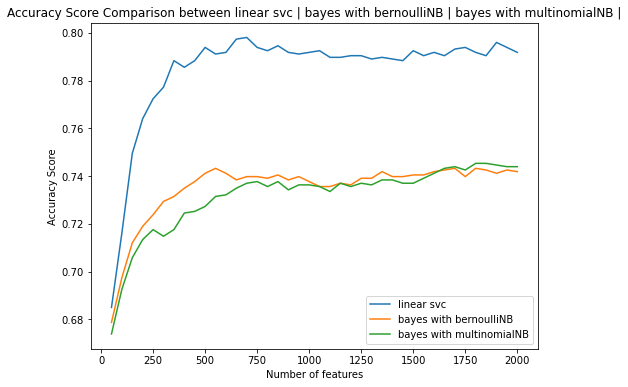

In [16]:
# accuracy diagram
plt.figure(figsize=(8,6))

title = "Accuracy Score Comparison between"

for name, df in nfeatures_accuracy:
    plt.plot(df.n_features, df.accuracy_score, label=name)
    title += " %s |" % name
plt.title(title)
plt.xlabel("Number of features")
plt.ylabel("Accuracy Score")
plt.legend()
plt.savefig("image/airline-accuracy-%d-with-neu.png" % MAX_FEATURE)

print("=== Accuracy Score ===\n")
for metrics in nfeatures_accuracy:
    max_accuracy_score_feature = 0
    max_accuracy_score = 0
    
    for feature_index in range(0, int((MAX_FEATURE-MIN_FEATURE)/FEATURE_INTERVAL)):
        _nfeatures = metrics[1].loc[feature_index].n_features
        _accuracy_score = metrics[1].loc[feature_index].accuracy_score
        # print("[%d] features -> [%f] accuracy score" % (_nfeatures, _accuracy_score))
        if _accuracy_score > max_accuracy_score:
            max_accuracy_score = _accuracy_score
            max_accuracy_score_feature = _nfeatures
    
    print("Model Name [%s] has max accuracy score [%f] at [%d] # of features" % (metrics[0], max_accuracy_score, max_accuracy_score_feature))

=== Balanced Accuracy Score ===

Model Name [linear svc] has max balanced accuracy score [0.731320] at [1900] # of features
Model Name [bayes with bernoulliNB] has max balanced accuracy score [0.589839] at [550] # of features
Model Name [bayes with multinomialNB] has max balanced accuracy score [0.586406] at [1800] # of features


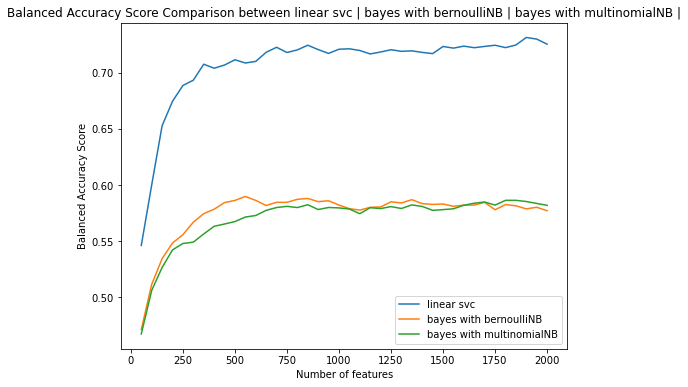

In [17]:
# accuracy diagram
plt.figure(figsize=(8,6))

title = "Balanced Accuracy Score Comparison between"

for name, df in nfeatures_balanced_accuracy:
    plt.plot(df.n_features, df.balanced_accuracy_score, label=name)
    title += " %s |" % name
plt.title(title)
plt.xlabel("Number of features")
plt.ylabel("Balanced Accuracy Score")
plt.legend()
plt.savefig("image/airline-balanced-accuracy-%d-with-neu.png" % MAX_FEATURE)

print("=== Balanced Accuracy Score ===\n")
for metrics in nfeatures_balanced_accuracy:
    max_balanced_accuracy_score_feature = 0
    max_balanced_accuracy_score = 0
    
    for feature_index in range(0, int((MAX_FEATURE-MIN_FEATURE)/FEATURE_INTERVAL)):
        _nfeatures = metrics[1].loc[feature_index].n_features
        _balanced_accuracy_score = metrics[1].loc[feature_index].balanced_accuracy_score
        # print("[%d] features -> [%f] accuracy score" % (_nfeatures, _accuracy_score))
        if _balanced_accuracy_score > max_balanced_accuracy_score:
            max_balanced_accuracy_score = _balanced_accuracy_score
            max_balanced_accuracy_score_feature = _nfeatures
    
    print("Model Name [%s] has max balanced accuracy score [%f] at [%d] # of features" % (metrics[0], max_balanced_accuracy_score, max_balanced_accuracy_score_feature))

=== Precision Score ===

Model Name [linear svc] has max Precision score [0.791025] at [700] # of features
Model Name [bayes with bernoulliNB] has max Precision score [0.756956] at [1650] # of features
Model Name [bayes with multinomialNB] has max Precision score [0.759784] at [1800] # of features


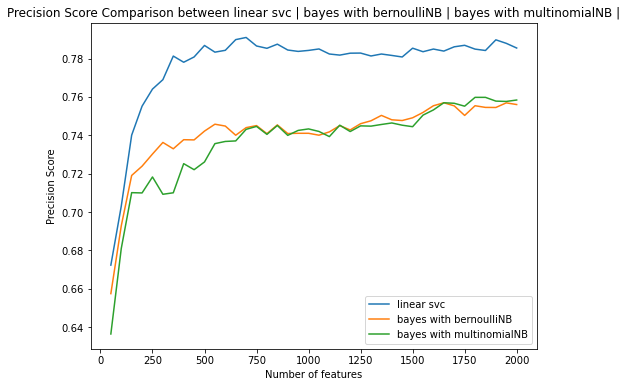

In [18]:
# precision diagram
plt.figure(figsize=(8,6))

title = "Precision Score Comparison between"

for name, df in nfeatures_precision:
    plt.plot(df.n_features, df.precision_score, label=name)
    title += " %s |" % name
plt.title(title)
plt.xlabel("Number of features")
plt.ylabel("Precision Score")
plt.legend()
plt.savefig("image/airline-precision-%d-with-neu.png" % MAX_FEATURE)

print("=== Precision Score ===\n")
for metrics in nfeatures_precision:
    max_precision_score_feature = 0
    max_precision_score = 0
    
    for feature_index in range(0, int((MAX_FEATURE-MIN_FEATURE)/FEATURE_INTERVAL)):
        _nfeatures = metrics[1].loc[feature_index].n_features
        _precision_score = metrics[1].loc[feature_index].precision_score
        # print("[%d] features -> [%f] Precision score" % (_nfeatures, _precision_score))
        if _precision_score > max_precision_score:
            max_precision_score = _precision_score
            max_precision_score_feature = _nfeatures
    
    print("Model Name [%s] has max Precision score [%f] at [%d] # of features" % (metrics[0], max_precision_score, max_precision_score_feature))

=== Recall Score ===

Model Name [linear svc] has max Recall score [0.798057] at [700] # of features
Model Name [bayes with bernoulliNB] has max Recall score [0.743234] at [550] # of features
Model Name [bayes with multinomialNB] has max Recall score [0.745316] at [1800] # of features


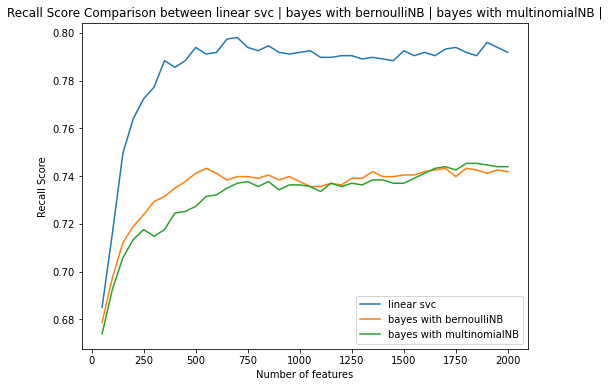

In [19]:
# recall diagram
plt.figure(figsize=(8,6))

title = "Recall Score Comparison between"

for name, df in nfeatures_recall:
    plt.plot(df.n_features, df.recall_score, label=name)
    title += " %s |" % name
plt.title(title)
plt.xlabel("Number of features")
plt.ylabel("Recall Score")
plt.legend()
plt.savefig("image/airline-recall-%d-with-neu.png" % MAX_FEATURE)

print("=== Recall Score ===\n")
for metrics in nfeatures_recall:
    max_recall_score_feature = 0
    max_recall_score = 0
    
    for feature_index in range(0, int((MAX_FEATURE-MIN_FEATURE)/FEATURE_INTERVAL)):
        _nfeatures = metrics[1].loc[feature_index].n_features
        _recall_score = metrics[1].loc[feature_index].recall_score
        # print("[%d] features -> [%f] Recall score" % (_nfeatures, _recall_score))
        if _recall_score > max_recall_score:
            max_recall_score = _recall_score
            max_recall_score_feature = _nfeatures
    
    print("Model Name [%s] has max Recall score [%f] at [%d] # of features" % (metrics[0], max_recall_score, max_recall_score_feature))

=== F1 Score ===

Model Name [linear svc] has max F1 score [0.791598] at [1900] # of features
Model Name [bayes with bernoulliNB] has max F1 score [0.707589] at [1350] # of features
Model Name [bayes with multinomialNB] has max F1 score [0.708189] at [1800] # of features


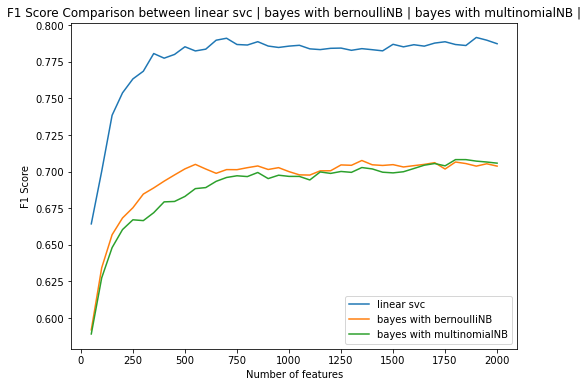

In [20]:
# f1 diagram
plt.figure(figsize=(8,6))

title = "F1 Score Comparison between"

for name, df in nfeatures_f1:
    plt.plot(df.n_features, df.f1_score, label=name)
    title += " %s |" % name
plt.title(title)
plt.xlabel("Number of features")
plt.ylabel("F1 Score")
plt.legend()
plt.savefig("image/airline-f1-%d-with-neu.png" % MAX_FEATURE)

print("=== F1 Score ===\n")
for metrics in nfeatures_f1:
    max_f1_score_feature = 0
    max_f1_score = 0
    
    for feature_index in range(0, int((MAX_FEATURE-MIN_FEATURE)/FEATURE_INTERVAL)):
        _nfeatures = metrics[1].loc[feature_index].n_features
        _f1_score = metrics[1].loc[feature_index].f1_score
        # print("[%d] features -> [%f] F1 score" % (_nfeatures, _f1_score))
        if _f1_score > max_f1_score:
            max_f1_score = _f1_score
            max_f1_score_feature = _nfeatures
    
    print("Model Name [%s] has max F1 score [%f] at [%d] # of features" % (metrics[0], max_f1_score, max_f1_score_feature))

### Performance Table
We generate a tale to summarize models' performances at 300 features.

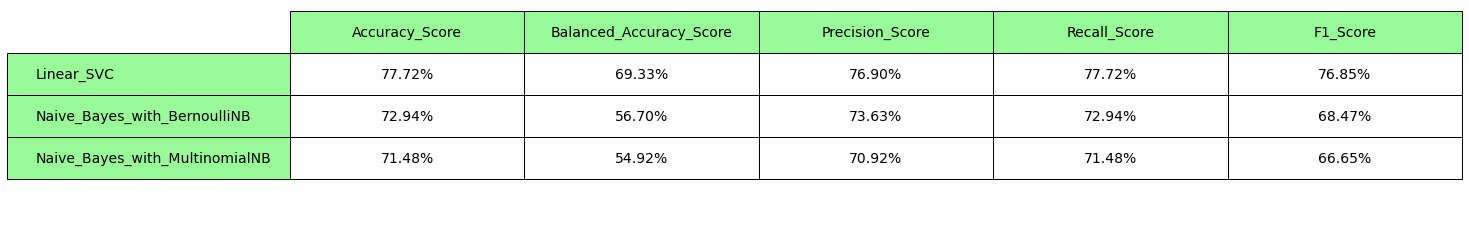

In [21]:
# precision, recall, f1, accuracy for all methods
# select # of features
loc_feature_index = SELECTED_FEATURE/FEATURE_INTERVAL - 1

lsvc_accuracy_score = nfeatures_accuracy[0][1].loc[loc_feature_index].accuracy_score
lsvc_balanced_accuracy_score = nfeatures_balanced_accuracy[0][1].loc[loc_feature_index].balanced_accuracy_score
lsvc_precision_score = nfeatures_precision[0][1].loc[loc_feature_index].precision_score
lsvc_recall_score = nfeatures_recall[0][1].loc[loc_feature_index].recall_score
lsvc_f1_score = nfeatures_f1[0][1].loc[loc_feature_index].f1_score

bcbn_accuracy_score = nfeatures_accuracy[1][1].loc[loc_feature_index].accuracy_score
bcbn_balanced_accuracy_score = nfeatures_balanced_accuracy[1][1].loc[loc_feature_index].balanced_accuracy_score
bcbn_precision_score = nfeatures_precision[1][1].loc[loc_feature_index].precision_score
bcbn_recall_score = nfeatures_recall[1][1].loc[loc_feature_index].recall_score
bcbn_f1_score = nfeatures_f1[1][1].loc[loc_feature_index].f1_score

bcmn_accuracy_score = nfeatures_accuracy[2][1].loc[loc_feature_index].accuracy_score
bcmn_balanced_accuracy_score = nfeatures_balanced_accuracy[2][1].loc[loc_feature_index].balanced_accuracy_score
bcmn_precision_score = nfeatures_precision[2][1].loc[loc_feature_index].precision_score
bcmn_recall_score = nfeatures_recall[2][1].loc[loc_feature_index].recall_score
bcmn_f1_score = nfeatures_f1[2][1].loc[loc_feature_index].f1_score

def to_percentage(list_val):
    return [str("%.2f" % (e*100)) + '%' for e in list_val]

val1 = ["Accuracy_Score", "Balanced_Accuracy_Score", "Precision_Score", "Recall_Score", "F1_Score",] 
val2 = ["Linear_SVC", "Naive_Bayes_with_BernoulliNB", "Naive_Bayes_with_MultinomialNB"] 
val3 = [[lsvc_accuracy_score, lsvc_balanced_accuracy_score, lsvc_precision_score, lsvc_recall_score, lsvc_f1_score],
        [bcbn_accuracy_score, bcbn_balanced_accuracy_score, bcbn_precision_score, bcbn_recall_score, bcbn_f1_score],
        [bcmn_accuracy_score, bcmn_balanced_accuracy_score, bcmn_precision_score, bcmn_recall_score, bcmn_f1_score]]
val3 = list(map(lambda a: to_percentage(a), val3))
  
fig, ax = plt.subplots() 
ax.set_axis_off() 
table = ax.table( 
    cellText = val3,  
    rowLabels = val2,  
    colLabels = val1, 
    rowColours =["palegreen"] * 10,  
    colColours =["palegreen"] * 10, 
    cellLoc ='center',  
    loc ='upper left')  


# table = ax.table(cellText=table_data, loc='center')
table.set_fontsize(14)
table.scale(3.5,3.5)
# ax.axis('off')

plt.show()